# Descripción del Problema
## Análisis de tópicos  

Partiendo del objetivo del trabajo final de la materia de Almacenamiento y recuperación de la información, el cual consiste en hacer un análisis de exhaustivo sobre tópicos y sentimientos de la base de datos semiestructurada “news.csv”, se hace importante reconocer que este tipo de estudios tienen como finalidad extraer información sobre la polaridad del texto, en este caso de estudio, las noticias de en “news.csv”.  

Así entonces, en primera instancia se hace un análisis de tópicos que tiene como objetivo general el reconocer los temas presentes en un conjunto de texto. Una de las metodologías más usadas para ello es el LDA. En particular esta consiste en reconocer cada texto como una mezcla al azar sobre los temas latentes en el conjunto de textos (o documentos), y cada tema se caracteriza por una distribución de Dirichlet de parámetros óptimos.  

<img src="pseudocodigo.png">
(Tomado de Andrades y López, 2011). 

Luego, para cada uno de los documentos, se busca el tema que le fue asignado. Esto se hace, como se menciona anteriormente, eligiendo una mezcla aleatoria de palabras para cada documento, que, al iterar sobre la mezcla, a mayor cantidad de palabras parecidas a un tópico, la probabilidad de que el documento lo contenga aumenta (Benítez, Valbuena, 2011).  

Andrades, J. A. B., & López, J. A. V. (2011). Motores de Búsqueda Web: Estado del arte en Probabilistic Latent Semantic Analysis y en Latent Dirichlet Allocation aplicado a problemas de acceso a la información en la Web. 

## Análisis de sentimientos 

El análisis de sentimientos puede verse desde dos enfoques globales (Liu, 2012). Uno de ellos consiste en el método de palabras asociadas (Pang, Lee, and Vaithyanathan, 2002), el cual toma el contexto del documento que contiene la palabra, en la frese, párrafo, etc., pudiendo discriminar el “sentimiento” o sentido detrás de cada n-gram. El segundo enforque, el cual se presenta en el caso de estudio, consiste en el análisis de la semántica (Turney, 2002) que muestra orientación o polaridad de un texto como una opinión. En esta metodología es necesario el procesamiento de indexación (mínimamente básico) del texto, con el fin de comparar los tokens con un diccionario indexado (lexicon) que contiene términos de polaridad positiva, negativa y neutra (apolar). Normalmente los sistemas incluyen tratamientos más avanzados ya que también contienen temimos modificadores (intensifican la polaridad de un término) o inversores (cambian al sentido contrario la palabra polarizada). Finalmente, la sumatoria de las polaridades da una aproximación global del “sentimiento” del conjunto de palabras consecutivas (frase), siendo globalmente positiva, negativa o neutra.

# Referencias

Liu, B. (2012). Sentiment analysis and opinion mining. Synthesis lectures on human language technologies, 5(1), 1-167. 

Pang, B., & Lee, L. (2008). Opinion mining and sentiment analysis. Foundations and Trends® in Information Retrieval, 2(1–2), 1-135. 

Turney, P. Semantic Orientation Applied to Unsupervised Classification of Reviews. In Proceedings of ACL-02, 40th Annual Meeting of the Association for Computational Linguistics(pp. 417-424). 

# Step by step (Resumen)

- se lanza un cluster en aws.
- la conexión se hace por consola y ssh al cluster desde el pc personal
- se procede a la instalación de jupyterhub y se clona el [repositorio](https://github.com/camilaMejia/trabajoFinal) del proyecto. con este notebook listo (En el github hay un archivo que se llama launch.txt donde están todas las instrucciones que se lanzan por comando)
- se instalan y cargan todas las librerías necesarias.
- se trae él .dat y el .csv desde S3 al almacenamiento local.
- se crea el índice invertido usando metapy.
- se hace el querying usando BM25.
- Se hace un LDA con todas las noticias (solo content + title).
- Para cada noticia se ve cual es el tópico dominante.
- se procede a la asignación de la polaridad de cada noticia utilizando textBlob.



# Procedimiento en AWS

Uno de los objetivos de este trabajo es evaluar la posibilidad de correr el proceso en máquinas virtuales y clusters de AWS. Para ello, se crea un cluster a traves de EMR y luego se crea un ambiente particular para instalar metapy.
Una de las dificultades a tener en cuenta es que estos clusters son efímeros por lo que no almacenan los notebooks, para esto lo que se hace es tener en cuenta que cuando se lanza el cluster además de instalar metapy y el resto de librerías necesarias se instala git para clonar todos los archivos necesarios menos él .dat y el .csv con todas las noticias dado que estos se encuentran en S3.
Para la parte de LDA con todos los datos es necesario correr spark en el cluster (no local) por eso para esta tarea se usaron los notebooks nativos de EMR. En la versión que se encuentra en este notebook en realidad solo se tiene un demo con 1000 noticias para por razones de tiempo, además que el EMR consume muchos más recursos y los 50 USD no son suficiente.

# Indexación y recuperación: metapy
Usando la librería metapy para ello se procede a configurar el archivo llamado minifig.toml en el cual se especifica en donde están los documentos que se van a indexar, junto con su formato, para luego hacer la recuperación.
En el proceso de indexación se procede a la creación del índice invertido que luego va a ser utilizado, en la sección de recuperación, para ello primero se define un modelo de ranking que para este caso se definió el BM25.

# LDA: spark
En este procedimiento se procede a usar las funciones de spark para leer la información de todas las noticias primero y luego hacer la representación vectorial de los documentos, después calculamos el índice invertido para finalmente hacer la reducción de dimencionalidad con LDA.

LDA asigna a cada noticia un vector de k posiciones en donde la posición $i$ expresa la probabilidad de que la noticia hable del tópico $i$. Además de esto a cada noticia se le puede asignar su tópico dominante.

Adicional a esto vemos que cada tópico tiene unas tokens que lo definen, dado que estos tópicos no son predeterminados es necesario que se haga un análisis de qué es cada cluster con base en esos tokens representativos (algo parecido a cuando en k-means se hace un análisis de los centroides).
Algo muy importante es que en este demo es necesario crear un contexto de spark (que además es local), por el contrario, en EMR el contexto ya es predeterminado.

# Sentiment Analysis
Para esta sección la idea inicial era entrenar un algoritmo sencillo, pero dado que no hay un sentimiento asociado (label), optamos por la opción de utilizar una librería que nos da un nivel de sentimiento en cada noticia según su polaridad (negativo o positivo).
La idea es usar textBlob y con base en la distribución de la polaridad vamos a asignar un sentimiento a cada noticia: Negativo, neutral o positivo


## Instalar librerias y complementos

In [ ]:
! pip install pandas
! pip install pyspark
! pip install metapy
! pip install boto3
! pip install nltk
! pip install numpy
! pip install matplotlib
! pip install TextBlob

# Cargar librerias

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import pyspark
from pyspark.sql import SQLContext
from pyspark.mllib.linalg import Vector, Vectors
from pyspark.mllib.clustering import LDA, LDAModel
import metapy
import requests, zipfile, io, os, boto3

import nltk
import numpy as np
import re
import codecs


from nltk.corpus import stopwords
from textblob import TextBlob



nltk.download('punkt')
nltk.download('stopwords')

 
stop_words_nltk = set(stopwords.words('english'))

from pyspark.ml.feature import HashingTF, IDF, Tokenizer, CountVectorizer
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.linalg import Vectors, SparseVector
from pyspark.ml.clustering import LDA, BisectingKMeans
from pyspark.sql.functions import monotonically_increasing_id
import re
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession

from pyspark.sql.types import StringType

sc = SparkContext('local', "app-topic-detection") 
spark = SparkSession(sc)

[nltk_data] Downloading package punkt to /home/hadoop/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/hadoop/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Cargar datos necesarios 

In [4]:
s3 =  boto3.client('s3', region_name='us-east-1')
with open('data/news/news.dat', 'wb') as f:
    s3.download_fileobj('finaltext','news.dat', f)



obj = s3.get_object(Bucket='finaltext', Key=u'news.csv')
df = pd.read_csv(obj['Body'])

df['all']=df.title + df.content

df2=df[['all']]
df2.to_csv('aux.csv')
df2.head(1000).to_csv('mini.csv')

# Análisis Descriptivo

<IPython.core.display.Javascript object>


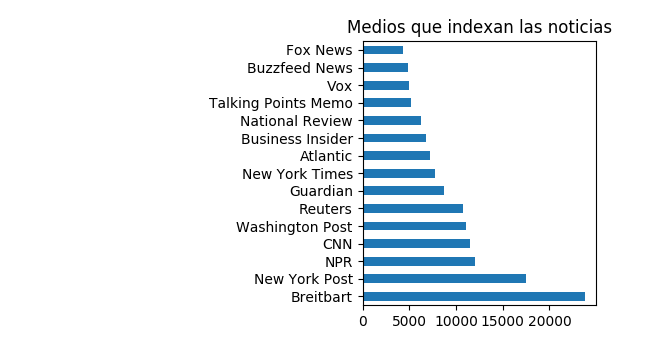

In [40]:
# tabla de frecuencia de medios que indexan las publicaciones
# en esta tabla quedan consignados los medios que publican las noticias
# que se encuantran consignadas en el dataset
pd.value_counts(df['publication'])

# grafico de barras de frecuencias de los medios que indexan las noticias
# en el grafico queda explicita la relacion de orden de mayor a menor 
# en el numero de noticias publicadas 
%matplotlib notebook


f = plt.figure(figsize=(10,2))
ax = f.add_subplot(122)
df['publication'].value_counts().plot(kind='barh',
                                            title='Medios que indexan las noticias', ax = ax)

<IPython.core.display.Javascript object>


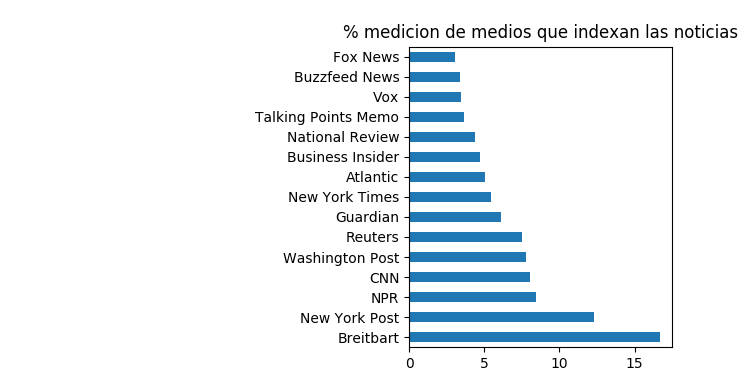

In [26]:
# tabla de frecuencias relativas para los medios que indexan las noticias
# de forma analoga a la abla anterior se mide el porcentaje de noticias
# que publica cada medio tomando como total todas las noticias del dataset
# grafico de barras de frecuencia relativa de los medios que indexan las noticias
# aqi queda consignado de manera grafica los porcentajes de publicaciones 
# que corresponden a cada medio
%matplotlib notebook
f = plt.figure(figsize=(10,2))
ax = f.add_subplot(122)
(100 * df['publication'].value_counts() / len(df['publication'])).plot(
                               kind='barh', title='% medicion de medios que indexan las noticias')

<IPython.core.display.Javascript object>


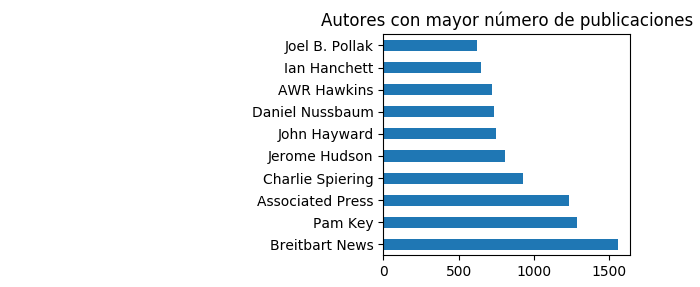

In [42]:
# la siguiente tabla deja ver de manera explicita
# los 11 autores con mayor numero de publicaciones
# relacionando autor con numero de publicaciones
AU = pd.value_counts(df['author'])
AU[0:10]

%matplotlib notebook
f = plt.figure(figsize=(10,2))
ax = f.add_subplot(122)
AU[0:10].plot( kind='barh', title='Autores con mayor número de publicaciones')

<IPython.core.display.Javascript object>


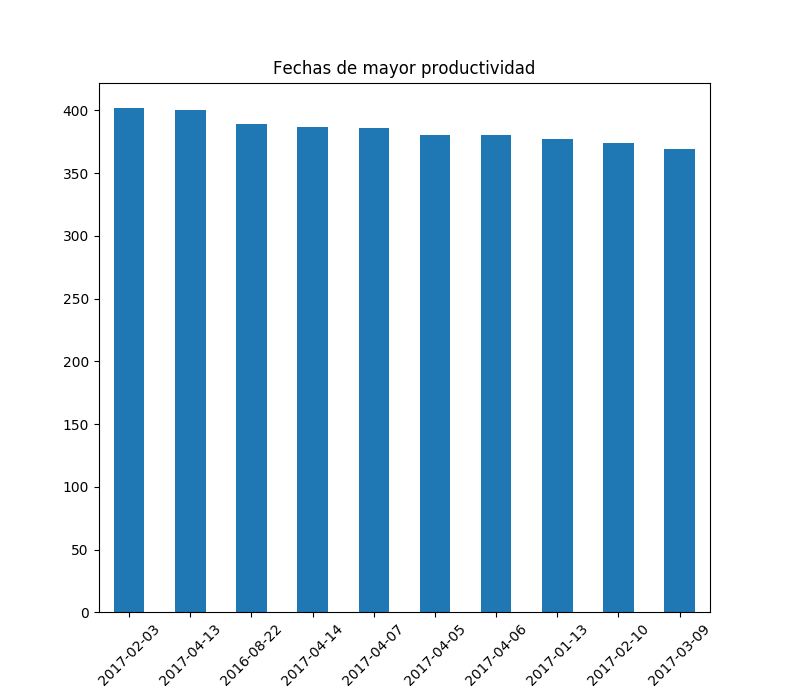

In [48]:
# la siguiente tabla muestra 
#las 11 fechas de mayor productividad

MS = pd.value_counts(df['date'])

MS[0:10]

#grafico de barras de las fechas con mayor indice
# de publicaciones y asociado su numero de publicaciones
%matplotlib notebook
f = plt.figure()
ax = f.add_subplot()
MS[0:10].plot(kind='bar',title= "Fechas de mayor productividad", ax = ax)
ax.tick_params(axis='x', labelrotation=45)

## Inverted index using metapy


In [ ]:
#!rm -rf news-idx
idx = metapy.index.make_inverted_index('miniconfig.toml')

print(f'Total de documentos: {idx.num_docs()}')
print(f'Cantidad de palabras únicas: {idx.unique_terms()}')
print(f'Promedio de longitud de los documentos: {idx.avg_doc_length()}')


# IR: Querys

In [ ]:
ranker = metapy.index.OkapiBM25(k1=1.2, b=0.75)
query = metapy.index.Document()
query.content('Trump hates china') # query from AP news
top_docs = ranker.score(idx, query, num_results=5)

print(top_docs)
index=[tup[0] for tup in top_docs]
df.loc[index,['title','content']]


# LDA on spark

### Pre process data

Here we load data to spark and make some preprocessing over the text

In [ ]:
#rawdata=spark.read.csv('aux.csv', inferSchema=True, header=True)

from nltk.stem import PorterStemmer, LancasterStemmer
from nltk.stem import WordNetLemmatizer

rawdata = spark.read.load("mini.csv", format="csv", header=True)

rawdata["all"].cast(StringType())




def cleanup_text(record):
    text  = record[1]
    uid   = record[0]
    
    # Default list of Stopwords
    sw = list(stop_words_nltk)
    

    tokens = nltk.word_tokenize(text)
    tokens = [ re.sub(r'[^A-Za-z0-9]+','',w) for w in tokens ] #Just letters and numbers
    tokens = [ w.lower() for w in tokens] #lowercase
    tokens = [ w for w in tokens if (len(w)>1) ] #Not single letter words
    tokens = [ w for w in tokens if w not in sw ] #Remove stopwords
    stemmer = PorterStemmer ()
    tokens =[stemmer.stem(token) for token in tokens]
    return tokens


udf_cleantext = udf(cleanup_text , ArrayType(StringType()))
clean_text = rawdata.withColumn("words", udf_cleantext(struct([rawdata[x] for x in rawdata.columns])))
clean_text.show()

### Embedings + LDA

here we create the features of each line and then make the LDA itself with k topics

In [ ]:
# Term Frequency Vectorization  - Option 2 (CountVectorizer)    : 
cv = CountVectorizer(inputCol="words", outputCol="rawFeatures", minDF = clean_text.count()*0.05)
cvmodel = cv.fit(clean_text)
featurizedData = cvmodel.transform(clean_text)

vocab = cvmodel.vocabulary
vocab_broadcast = sc.broadcast(vocab)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)

# Generate 25 Data-Driven Topics:
lda = LDA(k=5, seed=123, optimizer="em", featuresCol="features")

ldamodel = lda.fit(rescaledData)

#model.isDistributed()
#model.vocabSize()

ldatopics = ldamodel.describeTopics()
#ldatopics.show(25)

def map_termID_to_Word(termIndices):
    words = []
    for termID in termIndices:
        words.append(vocab_broadcast.value[termID])
    
    return words

udf_map_termID_to_Word = udf(map_termID_to_Word , ArrayType(StringType()))
ldatopics_mapped = ldatopics.withColumn("topic_desc", udf_map_termID_to_Word(ldatopics.termIndices))

### Show topics

In [ ]:
ldatopics_mapped.select(ldatopics_mapped.topic, ldatopics_mapped.topic_desc).show(50,False)

### Add detected topic to each line

In [ ]:
ldaResults = ldamodel.transform(rescaledData)

ldaResults.select('all','words','features','topicDistribution').show(10)

### Add principal topic to each line

In [ ]:
from pyspark.sql.types import IntegerType


def foo(topicDistribution):
    dom = topicDistribution[0]
    index_dom = 0
    for index in range(len(topicDistribution)):
        if (topicDistribution[index]>dom):
            dom=topicDistribution[index]
            index_dom=index
    return index_dom

udf_seltop = udf(foo , IntegerType())
aaa = ldaResults.withColumn("topic_prin", udf_seltop(ldaResults.topicDistribution))


aaa.select('all','topic_prin').show(10)

# Sentiment Analysis

In [ ]:

def p_pol(x):
    if x > p66:
        return "positivo"
    elif x < p33:
        return "negativo"
    else:
        return "neutral"

def sentiment_func(news):
    try:
        return TextBlob(news).sentiment
    except:
        return None


    
    
df_pandas=aaa.select('all','topic_prin').toPandas()

df=df2.head(df_pandas.shape[0]).copy()
    
%time df['sentimientos'] = df['all'].apply(sentiment_func)

df['polaridad'] = df['sentimientos'].apply(lambda x: x[0])
df['Subjetividad'] = df['sentimientos'].apply(lambda x: x[1])


p33=np.percentile(df['polaridad'],33)
p66=np.percentile(df['polaridad'],66)

df['feeling']=df['polaridad'].apply(p_pol)





df=df[['all','polaridad','Subjetividad','feeling']].merge(df_pandas)

df.to_csv('Sentiments_news.csv')


